### This notebook implements :
1. Perceptron fitting on data of 4 component task with full input data.
2. KAN fitting on data of 4 component task with full input data.

---
Functions, that are used in this notebook, are written in moduls:
* raw_data_processing.py
* json_tools.py

In [5]:
import os
import sys
import numpy as np
import pandas as pd
from copy import deepcopy

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import torch
from kan import KAN

In [6]:
from raw_data_processing import get_wavelength, get_x, get_y
from tools import JSON_Read

In [7]:
SCRIPT_DIR = os.path.abspath('')

## Loading data

In [8]:
d_config = JSON_Read("", "json_config.txt")
#locals().update(d_config)  # Transfer dict data to variables
d_config

{'SPEC_FOLDER': 'full_data',
 'EXCITE_WAVE_LENGTH': 350,
 'PREDICT_IONS': ['Cr'],
 'TRAIN_TEST_RATIO': 0.9,
 'VALIDATION_TRAIN_RATIO': 0.222,
 'RANDOM_STATE_SPLIT': 42,
 'N_ITER_NO_CHANGE': 100,
 'HIDDEN_LAYER_SIZES': 500,
 'RANDOM_STATE_TRAIN': 42,
 'ACTIVATION': 'tanh',
 'SOLVER': 'adam',
 'EARLY_STOPPING': True,
 'MAX_ITER': 1000}

In [9]:
EXCITE_WAVE_LENGTH = d_config['EXCITE_WAVE_LENGTH']
PREDICT_IONS = d_config['PREDICT_IONS']
SPEC_FOLDER = d_config['SPEC_FOLDER']

TRAIN_TEST_RATIO = d_config['TRAIN_TEST_RATIO']
VALIDATION_TRAIN_RATIO = d_config['VALIDATION_TRAIN_RATIO']
N_ITER_NO_CHANGE = d_config['N_ITER_NO_CHANGE']

HIDDEN_LAYER_SIZES = d_config['HIDDEN_LAYER_SIZES']
ACTIVATION = d_config['ACTIVATION']
SOLVER = d_config['SOLVER']

In [10]:
x = get_x(wave_length=EXCITE_WAVE_LENGTH, spec_file=""+SPEC_FOLDER)
y = get_y(l_ions=PREDICT_IONS, spec_file=""+SPEC_FOLDER)

In [11]:
x

,251.0,252.0,253.0,254.0,255.0,256.0,257.0,258.0,259.0,260.0,...,741.0,742.0,743.0,744.0,745.0,746.0,747.0,748.0,749.0,750.0
1,2.358,2.249,0.788,2.067,2.199,0.732,1.025,1.716,1.537,0.052,...,2.829,2.543,2.694,3.451,2.910,3.381,3.153,2.326,3.439,3.443
2,5.769,3.680,4.350,5.620,3.090,4.872,3.121,4.202,3.247,2.855,...,3.710,6.719,4.194,4.926,5.587,4.855,5.233,5.584,6.135,7.171
3,2.037,1.928,2.309,2.725,1.803,1.677,1.977,1.857,2.106,1.375,...,3.709,4.711,4.647,5.305,5.232,5.473,5.337,2.666,4.993,3.228
4,3.075,2.551,1.681,1.908,2.565,2.419,2.323,2.013,1.767,2.648,...,5.002,4.668,3.596,4.468,2.947,5.330,3.648,4.799,4.234,4.523
5,1.423,2.238,2.101,2.561,1.994,1.808,1.691,1.662,2.191,1.002,...,5.019,3.541,4.198,5.146,5.086,4.007,5.724,5.749,3.717,4.611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,4.932,2.551,2.051,2.668,1.659,2.705,2.637,1.642,2.294,2.138,...,4.665,3.308,3.899,2.836,3.634,3.602,4.800,4.638,3.036,5.293
997,4.008,3.593,2.359,2.731,2.395,2.859,1.878,2.170,2.887,0.898,...,3.452,4.428,3.616,4.664,4.877,4.359,5.153,3.957,4.406,4.507
998,3.214,2.987,3.374,3.145,2.788,2.231,2.414,1.673,2.372,2.171,...,3.111,3.621,3.163,3.341,4.779,3.578,6.185,3.565,4.193,4.088
999,3.257,2.987,3.121,3.626,1.442,3.501,1.814,2.174,1.252,1.788,...,3.904,3.065,3.455,3.551,3.164,4.492,4.171,3.796,5.633,4.440


In [12]:
y

array([0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  ,
       0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55,
       1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 ,
       1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 , 1.65,
       2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 , 1.65, 2.2 ,
       2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75,
       3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 ,
       3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85,
       4.4 , 4.95, 0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 ,
       4.95, 0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95,
       0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  ,
       0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55,
       1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 ,
       1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.

## Scaling data
Train / Validation / Test = 0.7 / 0.2 / 0.1

TRAIN_TEST_RATIO = (Train+Validation) / (Train+Validation+Test)

VALIDATION_TRAIN_RATIO = Validation / Train

In [22]:
RS = None

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=TRAIN_TEST_RATIO,
                                                    random_state=RS)

In [23]:
x_train.shape, x_test.shape

((900, 500), (100, 500))

In [24]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Model - MLP

Ordinary one-hidden-layer with 500 neurons perceptron.
We use MLPRegressor from scikit-learn library.

In [25]:
HIDDEN_LAYER_SIZES

500

In [31]:
model = MLPRegressor(hidden_layer_sizes=16,
                     activation=ACTIVATION,
                     solver=SOLVER,
                     early_stopping=True,
                     validation_fraction=VALIDATION_TRAIN_RATIO,
                     n_iter_no_change=N_ITER_NO_CHANGE,
                     learning_rate_init = 0.001,
                     learning_rate='adaptive')

In [32]:
VALIDATION_TRAIN_RATIO

0.222

In [33]:
# Обучение модели на тренировочных данных
model.fit(x_train, y_train)

c:\Users\Gavriil\VS_projects\KAN_spectroscopy\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='tanh', early_stopping=True, hidden_layer_sizes=16,
             learning_rate='adaptive', n_iter_no_change=100,
             validation_fraction=0.222)

In [34]:
def scatter_prediction_mlp(model, 
                           x, 
                           y_true, 
                           title = ""):
    """Evaluates MSE and R^2 of model. 
    Draws scatter plot of (y_true, y_predicted).
    Returns  (mse, r2)
    """
    y_pred = model.predict(x)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(y_true, y_pred, 'o', markersize=2, alpha = 0.2) 
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], markersize=2, alpha = 0.5, color='r') 
    ax.set_title(f"MSE={round(mse, 5)} | RMSE={round(mse**0.5, 5)} | R2={round(r2, 5)} | {title}")
    ax.set_xlabel("y_true")
    ax.set_ylabel("y_pred")
    plt.show()
    
    return mse, r2

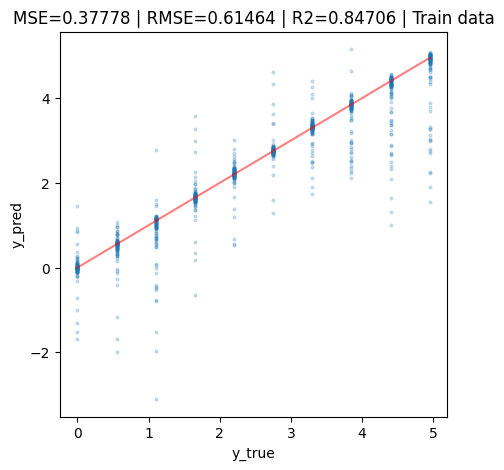

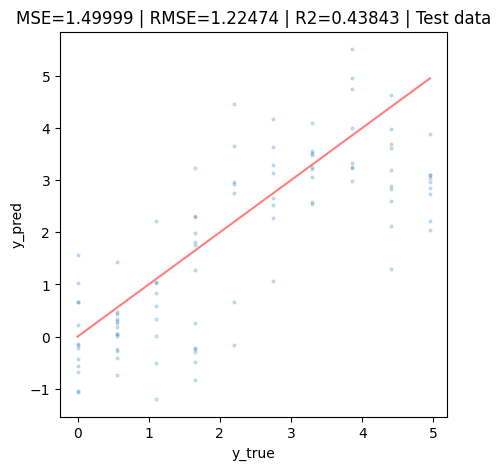

(1.499993055614422, 0.4384309479837061)

In [35]:
scatter_prediction_mlp(model, x_train, y_train, "Train data")
scatter_prediction_mlp(model, x_test, y_test, "Test data")

## KAN

New ML architecture, alternative to neural networks. Relies on the Kolmagprov-Arnold theorem about decomposition of function with many parameters:
$$ f(x_{1},\cdot\cdot\cdot, x_{n})=\sum_{q=1}^{2n+1}\Phi_{q}(\sum_{p=1}^{n}\varphi_{q,p}(x_{p})) $$

The main idea - represent $\Phi_{q}(\cdot)$ and $\varphi_{q,p}(\cdot)$ as a B-splines, and optimize their parameters during training.
After training it is possible to fit $\Phi_{q}(\cdot)$ and $\varphi_{q,p}(\cdot)$ by analytic formulas, post-train and express received KAN model as regular expression with analytic functions.


Some hyperparameteres of KANs (not all):
- grid: Number of grid intervals. 

Each function in KAN is represented in B-splines - in other words sum of polynoms, located on certain area of input parametere. Grid defines number of training parameteres and complexity of model. Number of grids can be gradually increased during training KAN - provided in "Gradially increasing grid" section.

- k: Order of piecewise polynomial in B-splines. k=3 provides smooth small order polynoms.

In [18]:
RS = None

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=TRAIN_TEST_RATIO,
                                                    random_state=RS)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

tc_x_train = torch.from_numpy(x_train)
tc_y_train = torch.from_numpy(y_train.reshape([-1,1]))
tc_x_test = torch.from_numpy(x_test)
tc_y_test = torch.from_numpy(y_test).reshape([-1,1])

dataset = {'train_input': tc_x_train,
           'train_label': tc_y_train,
           'test_input': tc_x_test,
           'test_label': tc_y_test}

In [19]:
# Some constants
K = 3 # order of piecewise polynomial in B-splines
INPUT_SHAPE = tc_x_test.shape[1]

In [20]:
def scatter_prediction_kan(model, 
                           x, 
                           y_true, 
                           title = ""):
    """Evaluates MSE and R^2 of model. 
    Draws scatter plot of (y_true, y_predicted).
    Returns  (mse, r2)
    """
    y_pred = model.forward(x).detach().numpy()
    y_true = y_true.detach().numpy()
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(y_true, y_pred, 'o', markersize=2, alpha = 0.2) 
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], markersize=2, alpha = 0.5, color='r') 
    ax.set_title(f"MSE={round(mse, 5)} | RMSE={round(mse**0.5, 5)} | R2={round(r2, 5)} | {title}")
    ax.set_xlabel("y_true")
    ax.set_ylabel("y_pred")
    plt.show()
    
    return mse, r2

## Grid = 3 | hidden neurons = 1

In [32]:
model1 = KAN(width=[INPUT_SHAPE, 1, 1], grid=3, k=K)
'''
model(dataset['train_input'])
model.plot(beta=100)
'''

"\nmodel(dataset['train_input'])\nmodel.plot(beta=100)\n"

In [33]:
result1 = model1.train(dataset, opt="LBFGS", steps=20, 
                       lamb=0,
                       lamb_l1=1,
                       lamb_entropy=2
                       )

train loss: 1.52e-01 | test loss: 3.64e-01 | reg: 4.45e+01 : 100%|██| 20/20 [02:57<00:00,  8.85s/it]


Text(0.5, 0, 'step')

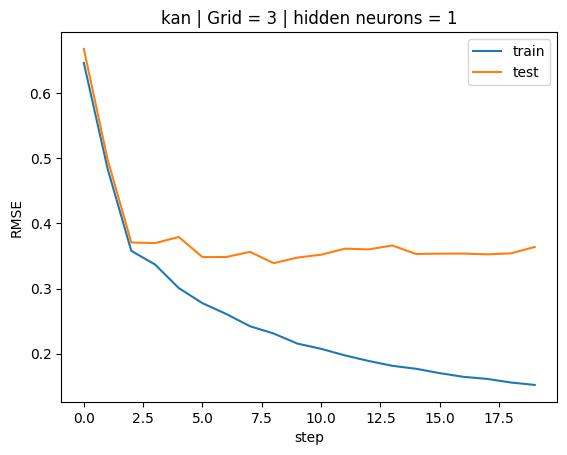

In [34]:
plt.plot(result1['train_loss'])
plt.plot(result1['test_loss'])
#plt.plot(result1['reg'])
plt.legend(['train', 'test']) #, 'reg'
plt.title('kan | Grid = 3 | hidden neurons = 1')
plt.ylabel('RMSE')
plt.xlabel('step')

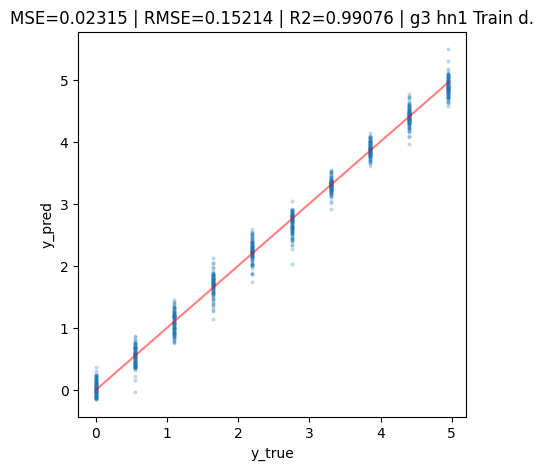

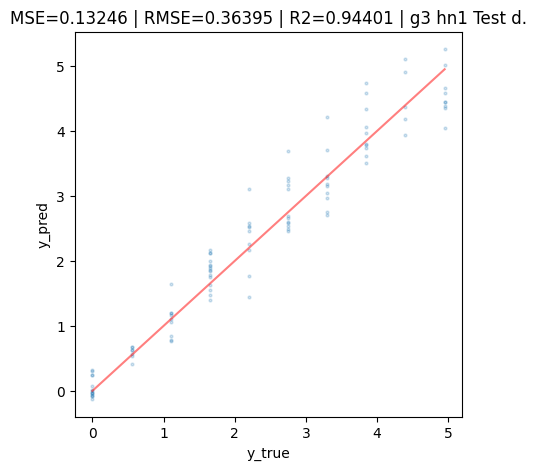

(0.13246163257473556, 0.9440117509734007)

In [35]:
scatter_prediction_kan(model1, tc_x_train, tc_y_train, "g3 hn1 Train d.")
scatter_prediction_kan(model1, tc_x_test, tc_y_test, "g3 hn1 Test d.") 

### Gradially increasing grid

In [32]:
width = [INPUT_SHAPE, 1, 1]
grids = np.array([3, 5, 7, 10])

train_losses = []
test_losses = []
steps = 10

for i in range(grids.shape[0]):
    if i == 0:
        model1_10 = KAN(width=width, grid=grids[i], k=K)
    if i != 0:
        model1_10 = KAN(width=width, grid=grids[i], k=K).initialize_from_another_model(model1_10, dataset['train_input'])
    results = model1_10.train(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    train_losses += results['train_loss']
    test_losses += results['test_loss']

description:   0%|                                                           | 0/10 [00:00<?, ?it/s]

train loss: 2.65e-01 | test loss: 4.64e-01 | reg: 3.36e+01 : 100%|██| 10/10 [01:35<00:00,  9.51s/it]
train loss: 1.90e-01 | test loss: 4.16e-01 | reg: 3.45e+01 : 100%|██| 10/10 [01:38<00:00,  9.86s/it]
train loss: 1.63e-01 | test loss: 5.22e+00 | reg: 3.42e+01 : 100%|██| 10/10 [01:44<00:00, 10.43s/it]
train loss: 1.06e-01 | test loss: 4.33e-01 | reg: 3.44e+01 : 100%|██| 10/10 [01:52<00:00, 11.30s/it]


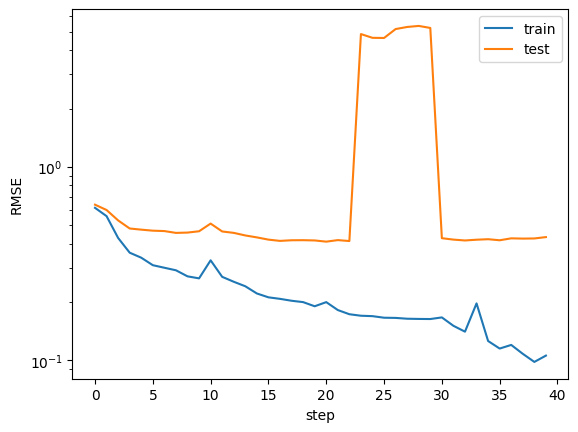

In [33]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

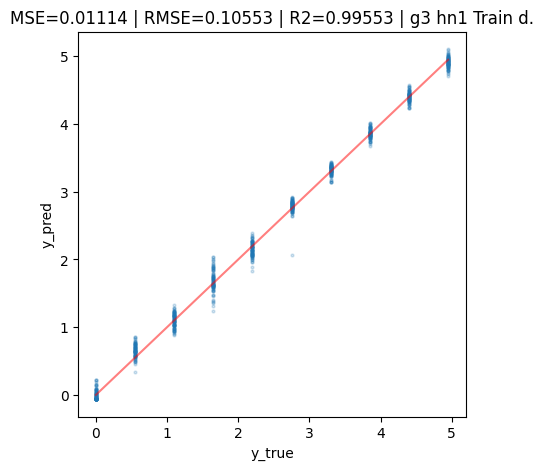

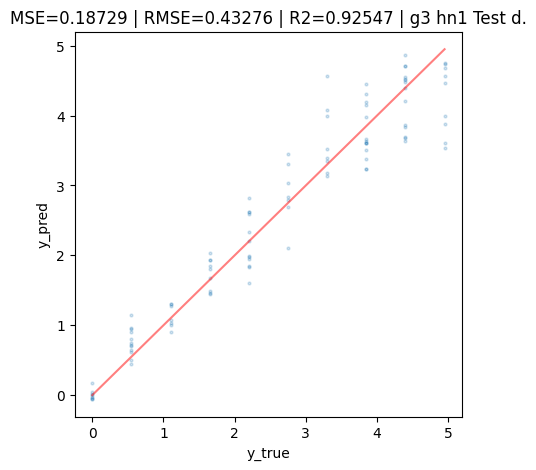

(0.18728543659516902, 0.9254739199239286)

In [36]:
scatter_prediction_kan(model1_10, tc_x_train, tc_y_train, "g3 hn1 Train d.")
scatter_prediction_kan(model1_10, tc_x_test, tc_y_test, "g3 hn1 Test d.") 

## Grid = 3 | hidden neurons = 2

In [19]:
model2 = KAN(width=[INPUT_SHAPE, 2, 1], grid=3, k=K)
'''
model(dataset['train_input'])
model.plot(beta=100)
'''

"\nmodel(dataset['train_input'])\nmodel.plot(beta=100)\n"

In [20]:
result2 = model2.train(dataset, opt="LBFGS", steps=20)

train loss: 9.34e-02 | test loss: 4.25e-01 | reg: 5.34e+01 : 100%|██| 20/20 [05:35<00:00, 16.79s/it]


Text(0.5, 0, 'step')

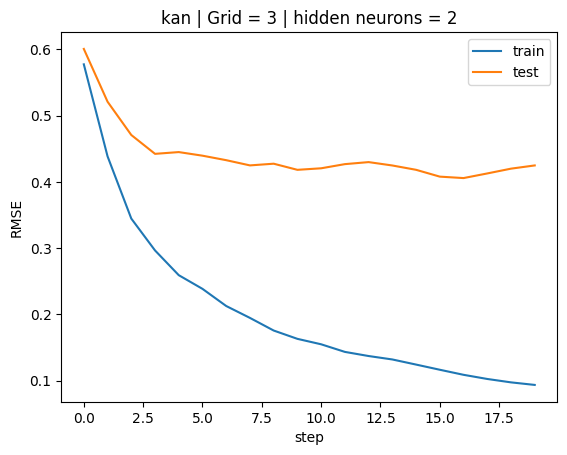

In [21]:
plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
plt.legend(['train', 'test'])
plt.title('kan | Grid = 3 | hidden neurons = 2')
plt.ylabel('RMSE')
plt.xlabel('step')

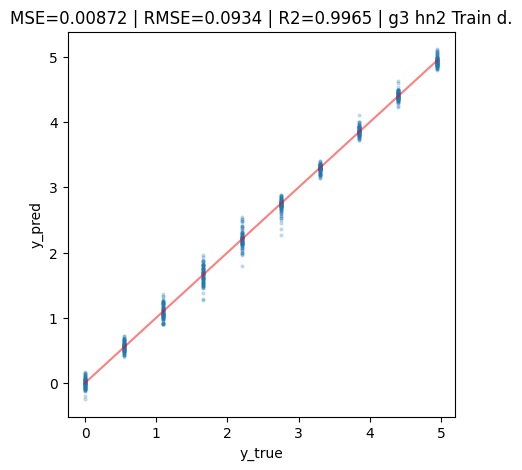

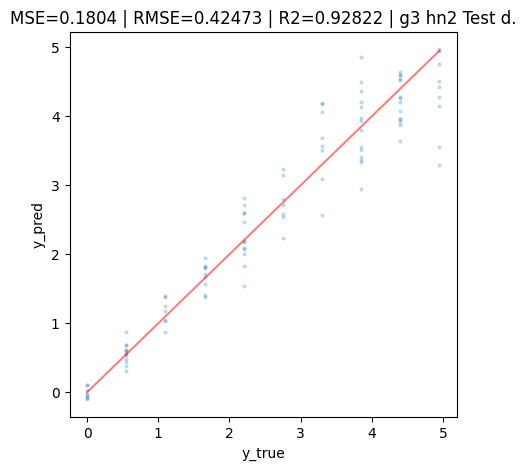

(0.1803959441111107, 0.9282154404494154)

In [22]:
scatter_prediction_kan(model2, tc_x_train, tc_y_train, "g3 hn2 Train d.")
scatter_prediction_kan(model2, tc_x_test, tc_y_test, "g3 hn2 Test d.")

-----
# Exploration code (main results are presented upper)

## Grid = 3 | hidden neurons = 5

In [23]:
model5 = KAN(width=[INPUT_SHAPE, 5, 1], grid=3, k=K)
'''
model(dataset['train_input'])
model.plot(beta=100)
'''

"\nmodel(dataset['train_input'])\nmodel.plot(beta=100)\n"

In [67]:
result5 = model5.train(dataset, opt="LBFGS", steps=20)

NameError: name 'model5' is not defined

Text(0.5, 0, 'step')

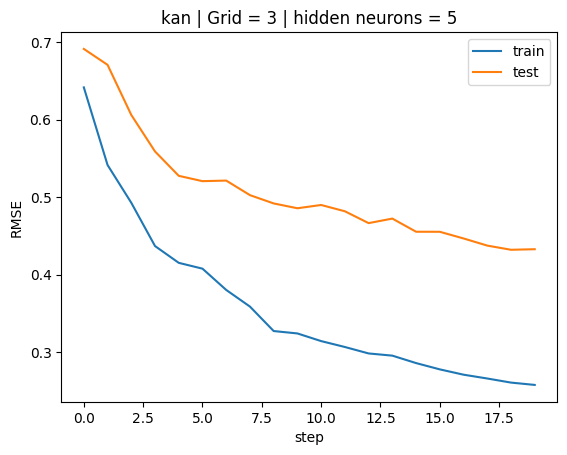

In [25]:
plt.plot(result5['train_loss'])
plt.plot(result5['test_loss'])
plt.legend(['train', 'test'])
plt.title('kan | Grid = 3 | hidden neurons = 5')
plt.ylabel('RMSE')
plt.xlabel('step')

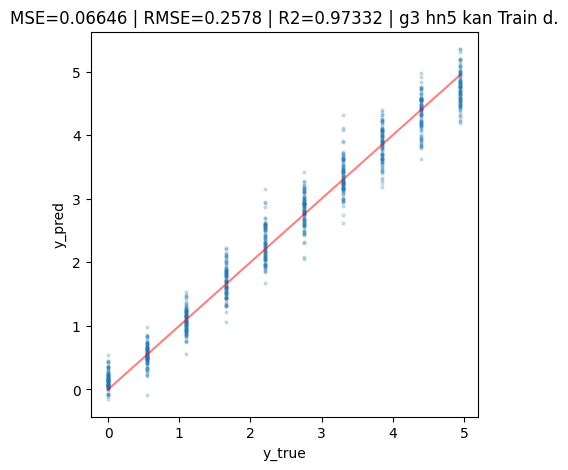

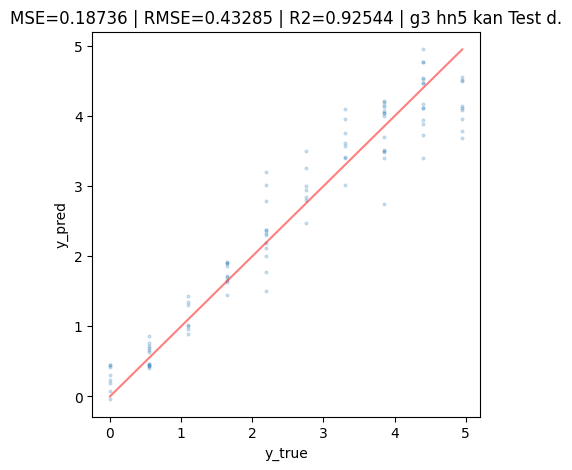

(0.18736105890927757, 0.9254438277035228)

In [26]:
scatter_prediction_kan(model5, tc_x_train, tc_y_train, "g3 hn5 kan Train d.")
scatter_prediction_kan(model5, tc_x_test, tc_y_test, "g3 hn5 kan Test d.")

## Grid=10 | hidden neurons = 5

In [28]:
model5_10 = KAN(width=[INPUT_SHAPE, 5, 1], grid=10, k=K)

result5_10 = model5_10.train(dataset, opt="LBFGS", steps=20)

train loss: 1.41e-01 | test loss: 4.33e-01 | reg: 5.81e+01 : 100%|██| 20/20 [19:08<00:00, 57.42s/it]


Text(0.5, 0, 'step')

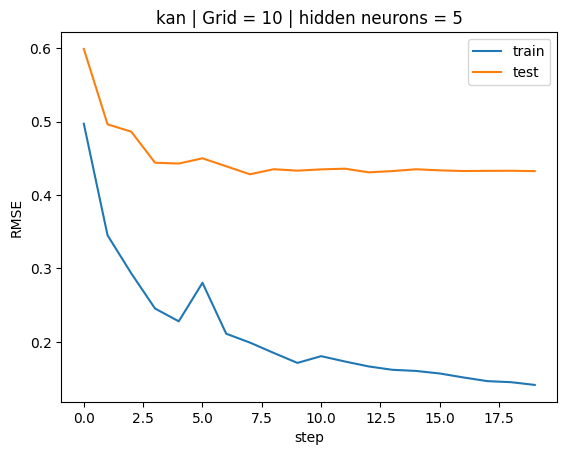

In [37]:
plt.plot(result5_10['train_loss'])
plt.plot(result5_10['test_loss'])
plt.legend(['train', 'test'])
plt.title('kan | Grid = 10 | hidden neurons = 5')
plt.ylabel('RMSE')
plt.xlabel('step')
#plt.yscale('log')

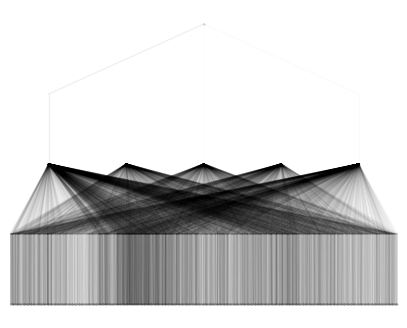

In [36]:
model5_10.plot(beta=3)

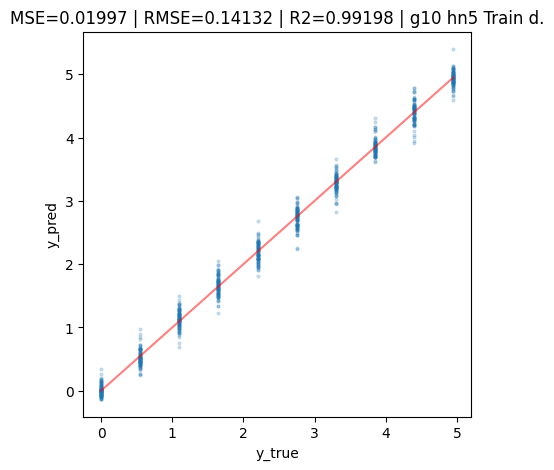

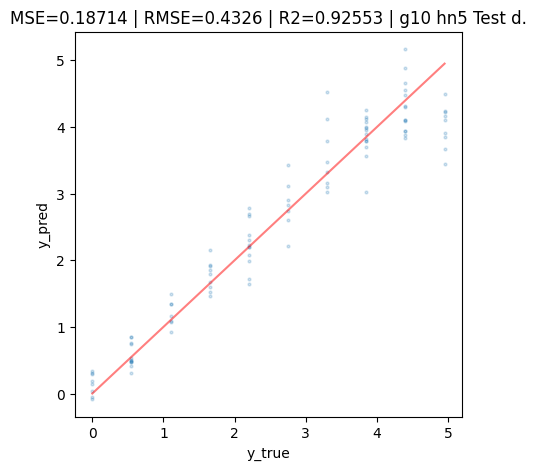

(0.18714075871402847, 0.9255314912735815)

In [30]:
scatter_prediction_kan(model5_10, tc_x_train, tc_y_train, "g10 hn5 Train d.")
scatter_prediction_kan(model5_10, tc_x_test, tc_y_test, "g10 hn5 Test d.")

### Gradually increasing grid

In [42]:
width = [INPUT_SHAPE, 5, 1]
grids = np.array([3, 5, 7, 10])

train_losses = []
test_losses = []
steps = 50

for i in range(grids.shape[0]):
    print(i)
    if i == 0:
        model5_1_10 = KAN(width=width, grid=grids[i], k=K)
    if i != 0:
        model5_1_10  = KAN(width=width, grid=grids[i], k=K).initialize_from_another_model(model5_1_10 , dataset['train_input'])
    results = model5_1_10 .train(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    train_losses += results['train_loss']
    test_losses += results['test_loss']

0


train loss: 5.30e-01 | test loss: 6.55e-01 | reg: 6.20e+01 :   4%|   | 2/50 [01:35<38:03, 47.56s/it]


KeyboardInterrupt: 

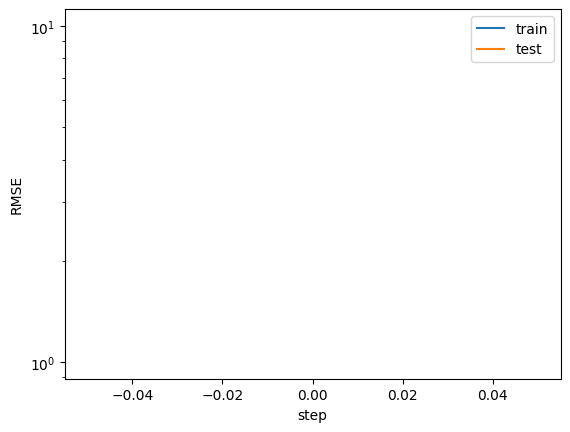

In [39]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

### Pruning

In [ ]:
model2 = model.prune()
model2(dataset['train_input'])
model2.plot()